In [1]:
import numpy as np
import scipy.integrate as sc
import scipy.interpolate as ip
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
plt.rcParams['figure.figsize'] = [10, 6]
from scipy.interpolate import CubicSpline

The following code explores the possibility of creating a method for relating a non-thermal velocity distribution of dark matter to its transfer function T(k) and ultimately its matter power spectrum P(k), without the need to solve the Boltzmann Hierarchy. This is done by first translating a distribution in terms of comoving momentum (q = ap/m) to a distribution in real space (s), where f(s) = f(q(s)) (ds/dq)^-1. Then the 3d Fourier transform of said distribution can be taken, however, the theta a phi components may be handled analytically leaving a 1D Fourier transform which must be handled numerically. The result of this transform can then be compared to the known transfer functions computing using the Cosmic Linear Anisotropy Solving System (CLASS).


THE CELL BELOW INCLUDES:

GENERATING A REAL SPACE DISTRIBUTION (s) FROM A COMOVING MOMENTUM (q) DISTRIBUTION

- MAPPING Q TO S

- CALCULATING dsdq^-1

- CALCULATING f(q(s))

- FINDING FULL f(s) = f(q(s)) * (dsdq)^-1



s value from a q value of 1e-07: 0.3544713657613986
associated k val: 2.821102341657461
error: 0.0011919538390401385


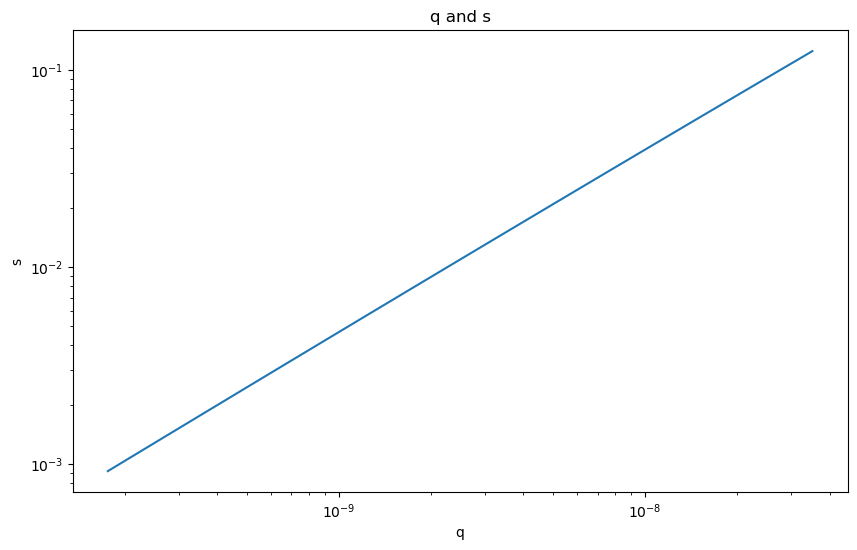

/tmp/ipykernel_208523/509277074.py:88: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  dsdq = (s[i]/q[i]) - q[i]**2 * sc.quad(dsdq_integrand, 0, 1, args = (q[i], H_0, w_r, w_m))[0] # dsdq = s/q - q^2 * integrand


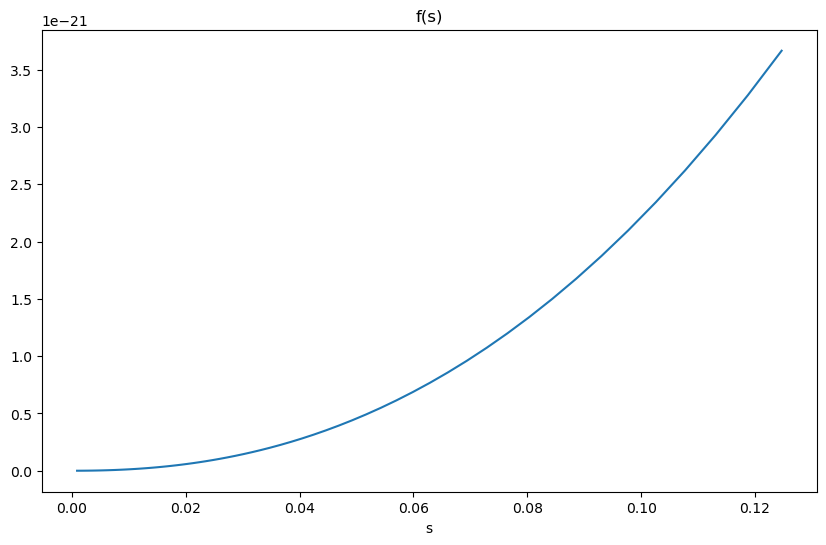

In [2]:
# setting number of q values to evaluate at
grainynes = 100


T_d = 10**9 # decoupling temp of dark matter species, eV
m = 10**6 # mass of dark matter species, eV


# dist name and constant values (shape deviation) for some 1D distribution
dist_name = 'NAME' 
d=-0.01 
g=0.1 
c=10 
r=10
tail_multiplier = 0 #distribution kurtosis


#Hubble parameters
H_0 = 100.0 / (3.0 * 10**(5)) # 1/Mpc, using 100 to account for k/h unit from CLASS software
w_r = 8.97 * 10**(-5) #radiation density parameter
w_m = 0.27 #matter density parameter
w_de = 0.73 #dark energy density parameter
a = 1 #scale factor today


#1D f(q) function
def fq_1d(q, m, T_d):
    b = np.sqrt((q**2 + (m**2/(T_d**2))))

    y = ((1 + d* np.exp(q**g))/(np.exp(b) + 1)) + (c * np.exp((-q**2)/r) * np.exp(-q/10))
    tail = tail_multiplier * y
    return (y + tail) * q**2


#numerical integration needed to map q to s
#integrand for mapping
def mapping_integrand(a, q, H_0, w_r, w_m, w_de):
    H = H_0 * np.sqrt(w_r * a**(-4) + w_m * a**(-3) + w_de) 
    return 1 / (np.sqrt(a**2 + q**2) * a**2 * H) # actual integrand



# setting up list of q values for mapping function
q_before = np.logspace(-1, 1.3,  grainynes)


# conversions to match output of CLASS software
tncdm = 7.5 *  2.35E-10 
q = []
for qval in q_before:
    temp = (qval*(tncdm)) 
    q.append(temp)


# making new q values into a numpy array for better handling
q = np.array(q)


# MAPPING FROM Q TO S
s = []
for val in q: 
    temp =  val * sc.quad(mapping_integrand, 0, 1, args = (val, H_0, w_r, w_m, w_de))[0] # s = q * integrand, for every q value
    s.append(temp)


# CHECKING Q TO S MAPPING
q_value = 10**(-7) # q value you want to check
print(f's value from a q value of {q_value}: {q_value * sc.quad(mapping_integrand, 0, 1, args = (val, H_0, w_r, w_m, w_de))[0]}') # print the mapped s value from given q value
print(f'associated k val: {1 / (q_value * sc.quad(mapping_integrand, 0, 1, args = (val, H_0, w_r, w_m, w_de))[0])}') # print 1/s, k (wavenumber)
print(f'error: {sc.quad(mapping_integrand, 0, 1, args = (val, H_0, w_r, w_m, w_de))[1]}') # print the error

# PLOTTING Q AND S
#ensure expected linearity
plt.loglog(q, s)
plt.xlabel('q')
plt.ylabel('s')
plt.title ('q and s')
plt.show()

# CALCULATING ds/dq
dsdq_inv = []
def dsdq_integrand(a, q, H_0, w_r, w_m):
    H = H_0 * np.sqrt(w_r * a**(-4) + w_m * a**(-3))
    return 1 / ((a**2 + q**2)**(3/2) * a**2 * H) 

# dsdq for every s and q value pair
for i in range(len(q)):
    dsdq = (s[i]/q[i]) - q[i]**2 * sc.quad(dsdq_integrand, 0, 1, args = (q[i], H_0, w_r, w_m))[0] # dsdq = s/q - q^2 * integrand
    dsdq_inv.append(1/dsdq) # take the inverse 


# FINDING f(q(s))
qofs = interp1d(s, q) # interpolating to get q as a function of s
new_q = qofs(s) # calling interpolation function to get a q(s)


# GETTING FULL f(s) FUNCTION
f_s = fq_1d(new_q, m, T_d) * dsdq_inv # applying q(s) to f(q) for f(q(s)) and multiplying by inverse of dsdq

# PLOTTING FULL f(s) FUNCTION
plt.plot(s, f_s)
plt.title('f(s)')
plt.xlabel('s')
plt.show()



THE CELL BELOW INCLUDES:

- EXPORTING f(s) FROM NUMERICAL INTEGRATION IN MATHEMATICA TO CHECK ACCURACY OF EARLIER SCIPY INTEGRATION

In [4]:
#Specify the filename
filename_s = '/mnt/c/Users/Meredith/Downloads/class_public-3.2.0/fourier_lists/s_list'

# Open the file in write mode
with open(filename_s, 'w') as file:
    for s_val in s:
        file.write(f"{s_val}\n")

# Specify the filename
filename_fs = '/mnt/c/Users/Meredith/Downloads/class_public-3.2.0/fourier_lists/fs_list'

# Open the file in write mode
with open(filename_fs, 'w') as file:
    for fs_val in f_s:
        file.write(f"{fs_val}\n")

THE CELL BELOW INCLUDES:

- IMPORTING p(K) DATA COMPUTED BY CLASS SOFTWARE

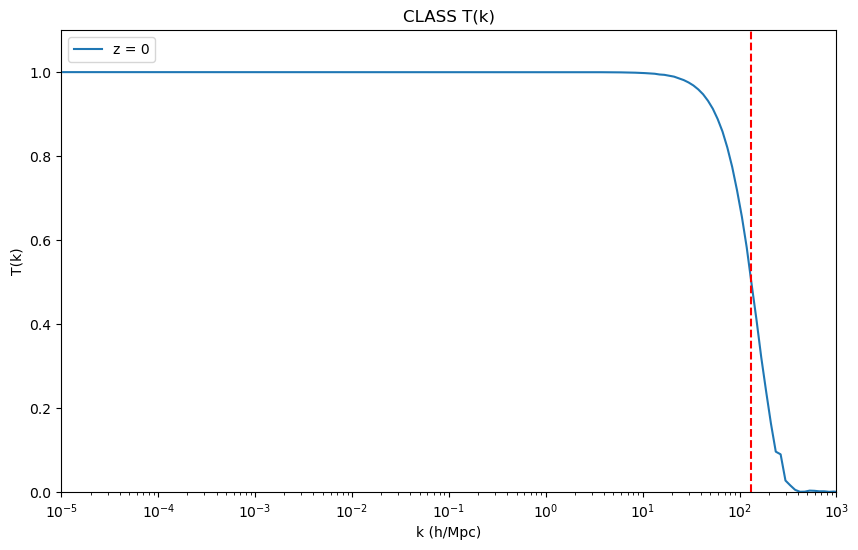

In [6]:

# load in dist P(k)
data = np.loadtxt('/mnt/c/Users/Meredith/Downloads/class_public-3.2.0/output/NEW3_ztest_000_pk.dat', skiprows=4)
k_NEW3 = data[:, 0]  # First column: k (h/Mpc)
Pk_NEW3 = data[:, 1]  # Second column: P(k)

# load in lambda cdm P(k)
data_lcdm = np.loadtxt('/mnt/c/Users/Meredith/Downloads/class_public-3.2.0/output/lcdm_ztest_000_pk.dat', skiprows=4)
k_lcdm = data_lcdm[:, 0]  # First column: k (h/Mpc)
Pk_lcdm = data_lcdm[:, 1]  # Second column: P(k)


# GET TRANSFER FUNCTION
transfer = np.sqrt(Pk_NEW3 / Pk_lcdm)


# PLOT TRANSFER FUNCTION
plt.semilogx(k_NEW3 , transfer, label = 'z = 0') #transfer function at redshift z=0
plt.xlim(0.00001, 10**(3))
plt.ylim(0, 1.1)
plt.xlabel('k (h/Mpc)')
plt.ylabel('T(k)')
plt.title('CLASS T(k)')
plt.legend()
plt.axvline(x=90/0.68, color='r', linestyle='--') #expected k-half mode



THE CELL BELOW INCLUDES:

- IMPORTING FOURIER DATA FROM MATHEMATICA TO ENSURE ACCURACY OF LATER SCIPY INTEGRATION

In [7]:
data = np.loadtxt('/mnt/c/Users/Meredith/Downloads/class_public-3.2.0/fourier_lists/mathematica_list.dat')
k_mathematica = data[:, 0]
foriye_mathmatica = data[:, 1]

THE CELL BELOW INCLUDES:

- NUMERICALLY INTEGRATION FOR FOURIER TRANSFORM OVER S

- NORMALIZING RESULT TO MATCH CLASS T(k) PRIOR TO CUTOFF

- METHOD FOR ADJUSTING K VALUES TO CHECK SHAPE MATCH BETWEEN TRANSFER FUNCTIONS

- PLOTTING BOTH RESULTS AND INTEGRAND

NOTE ON FINAL RESULT TO BE RESOLVED IN FURTHER WORK:

- SHAPE DEVIATION MOST LIKELY CAUSED BY SELF-GRAVITY OF DARK MATTER

- CUT-OFF DEVIATION MOST LIKELY CAUSED BY GRAVITATIONAL POTENTIAL TERM (USING MUCH HIGHER REDSHIFT COULD MITIGATE THIS)

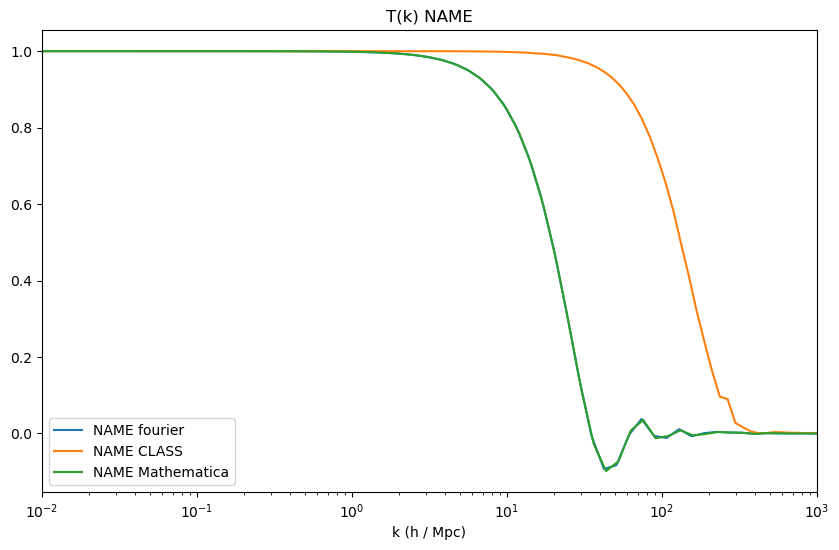

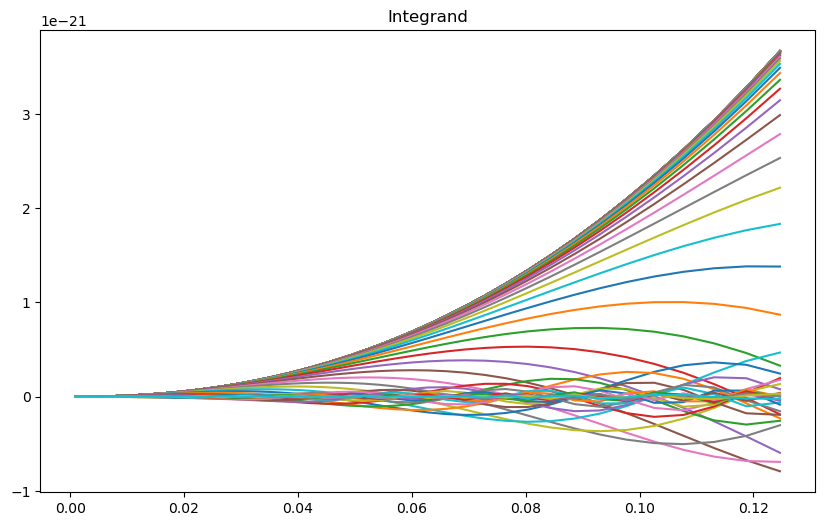

In [8]:
# FUNCTION FOR f(s)
fs_interp = interp1d(s, f_s) #interpolating to get function we can numerically integrate


# fourier integrand that is left after theta and phi integrals have been handled analytically
def fourier_integrand(s, k):
    return fs_interp(s) * (np.sin(k*s)/(k*s)) # f(s)_1d * sin(ks) / ks


# setting up k values
k = np.logspace(-5, 3, grainynes)


# COMPUTING INTEGRAL FOR EVERY K VALUE IN THE LIST
foriye = []
for idx in range(len(k)):
    foriye_temp = sc.quad(fourier_integrand, s[0], s[-1] , args = (k[idx]))[0] # integrating from first to last s value to avoid computational issues
    foriye.append(4 * np.pi * foriye_temp) # 4 pi from analytical theta and phi


# normalizing result to 1 to match CLASS
max_value = np.max(np.abs(foriye))
foriye_normalized = foriye / max_value


# ADJUSTING K VALUES OF FOURIER RESULT TO CHECK SHAPE AGAINST CLASS T(k)
new_k = []
for k in k:
    further = k * 1 #adjust as needed
    new_k.append(further)

#filepath to save plotted image
filepath_pic = f'/mnt/c/Users/Meredith/Downloads/class_public-3.2.0/pics_fourier/{dist_name}'


# PLOTTING FOURIER T(k) AND CLASS T(K)
plt.semilogx(new_k, foriye_normalized, label = f'{dist_name} fourier') # fourier result
plt.semilogx(k_NEW3, transfer, label = f'{dist_name} CLASS') # CLASS result
plt.semilogx(k_mathematica, foriye_mathmatica, label = f'{dist_name} Mathematica') # Mathematica fourier result
plt.xlim(10**(-2), 10**(3))
plt.title(f'T(k) {dist_name}')
plt.xlabel('k (h / Mpc)')
plt.legend()
plt.savefig(filepath_pic)
plt.show()


#PLOTTING INTEGRAND
s = np.array(s)
k_ranger = np.logspace(-3, 3, grainynes) # k modes you want to look at
for k in k_ranger:
    integrand_val = fourier_integrand(s, k)
    plt.plot(s, integrand_val, label = f'k = {round(k, 4)}')
    # plt.legend() #only do this for small number of k modes
    plt.title('Integrand')
